In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression

In [2]:
scene_df = pd.read_hdf('C:/Users/WillQuantique/OneDrive - univ-lyon2.fr/Fac/M1/DataChallege/dataset_for_students/scene.hdf5')
calibration_df = pd.read_hdf('C:/Users/WillQuantique/OneDrive - univ-lyon2.fr/Fac/M1/DataChallege/dataset_for_students/calibration_set_1.hdf5')

#### Temporal averaging

In [3]:
def find_closest_calibration_image(scene_temp, calibration_data):
    calibration_temperatures = calibration_data['t_cn'].values
    closest_index = (np.abs(calibration_temperatures - scene_temp)).argmin()
    return calibration_data.iloc[closest_index]['image']

# Function to estimate offset and responsivity
def estimate_parameters(calibration_images, calibration_temperatures):
    height, width = calibration_images[0].shape
    num_pixels = height * width
    
    # Reshape images for linear regression
    images_reshaped = np.array([img.ravel() for img in calibration_images])
    
    offsets = np.zeros(num_pixels)
    responsivities = np.zeros(num_pixels)
    
    for i in range(num_pixels):
        model = LinearRegression().fit(calibration_temperatures.reshape(-1, 1), images_reshaped[:, i])
        offsets[i] = model.intercept_
        responsivities[i] = model.coef_[0]
    
    # Reshape back to original image shape
    offsets = offsets.reshape(height, width)
    responsivities = responsivities.reshape(height, width)
    
    return offsets, responsivities

# Function to apply NUC with handling for division by zero
def apply_nuc(raw_image, offset_image, resp_image):
    with np.errstate(divide='ignore', invalid='ignore'):
        corrected_image = (raw_image - offset_image) / resp_image
        corrected_image[~np.isfinite(corrected_image)] = 0  # Set -inf, inf, NaN to 0
    return corrected_image

# Function to denoise image with handling for NaN values
def denoise_image(image):
    image = np.nan_to_num(image)  # Replace NaN with 0
    return cv2.fastNlMeansDenoising(image.astype(np.uint8), None, 30, 7, 21)

def update(frame):
    raw_image = scene_df['image'].iloc[frame]
    corrected_image = apply_nuc(raw_image, offset_image, resp_image)
    denoised_image = denoise_image(corrected_image)

    # Update plots
    original_image_plot.set_data(raw_image)
    corrected_image_plot.set_data(corrected_image)
    denoised_image_plot.set_data(denoised_image)

    # Update scene data
    scene_df.at[frame, 'corrected_image'] = corrected_image
    scene_df.at[frame, 'denoised_image'] = denoised_image

    return original_image_plot, corrected_image_plot, denoised_image_plot

In [4]:
# Ensure all images are correctly typed
scene_df['image'] = scene_df['image'].apply(lambda img: img.astype(np.float32))
calibration_df['image'] = calibration_df['image'].apply(lambda img: img.astype(np.float32))

# Process each scene image
calibration_images = calibration_df['image'].values
calibration_temperatures = calibration_df['t_cn'].values

offset_image, resp_image = estimate_parameters(calibration_images, calibration_temperatures)

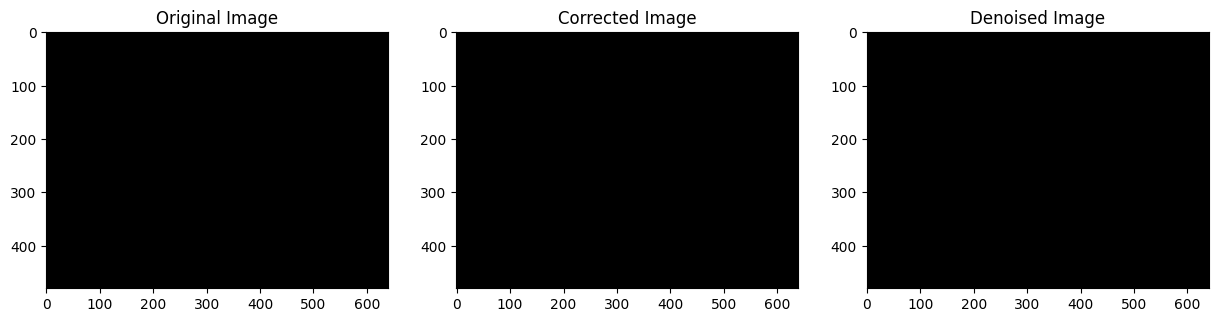

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title("Original Image")
axs[1].set_title("Corrected Image")
axs[2].set_title("Denoised Image")

original_image_plot = axs[0].imshow(np.zeros_like(scene_df['image'].iloc[0]), cmap='gray')
corrected_image_plot = axs[1].imshow(np.zeros_like(scene_df['image'].iloc[0]), cmap='gray')
denoised_image_plot = axs[2].imshow(np.zeros_like(scene_df['image'].iloc[0]), cmap='gray')

In [6]:
ani = animation.FuncAnimation(fig, update, frames=len(scene_df), blit=True)
plt.show()

ValueError: could not broadcast input array from shape (480,640) into shape (640,)

In [ ]:
from IPython.display import display, clear_output
import time

# Function to display images in a loop
def display_images(images, interval=0.001):
    plt.figure(figsize=(10, 6))
    for img in images:
        plt.imshow(img, cmap='gray')
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(interval)

# Display the corrected images
display_images(linear_reg_scene_images)